In [1]:
import geopandas as gpd
import pandas as pd
from numpy import mean
import matplotlib.pyplot as plt
import branca.colormap as cm
import xyzservices.providers as xyz
import folium

plt.style.use('ggplot')

In [2]:
df=gpd.read_file('ship557.csv')
ports=gpd.read_file('ports.csv')
ports2=gpd.read_file(r'C:\thalassaDB\piraeus_port\piraeus_port.shp').to_crs('epsg:2100')

In [15]:
print(f'Chosen vessel_id :{df.vessel_id[0]}')

Chosen vessel_id :84872dde83fa3649fba717401ad1ceb3de83b0585f476fb1cba40efe9994b398


In [3]:
gdf=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.lon,df.lat,crs="EPSG:4326")).to_crs('epsg:2100')
ports1=gpd.GeoDataFrame(ports,geometry=gpd.points_from_xy(ports.lon,ports.lat,crs="EPSG:4326")).to_crs('epsg:2100')

ports1.set_index('name',inplace=True)
ports1.drop(index='PIRAEUS',inplace=True)
ports1.reset_index(inplace=True)
ports=ports1.append({'name':'PIRAEUS','geometry':ports2.geometry[0]},ignore_index=True).set_crs(epsg = "2100")


gdf.dt=gdf.dt.apply(lambda x: pd.to_datetime(x))
gdf=gdf.sort_values(by=['dt'])
gdf=gdf.reset_index(drop=True)
gdf.speed=pd.to_numeric(gdf.speed)

C:\Users\manol\AppData\Local\Temp\ipykernel_7448\2536270229.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ports=ports1.append({'name':'PIRAEUS','geometry':ports2.geometry[0]},ignore_index=True).set_crs(epsg = "2100")
c:\Users\manol\anaconda3\envs\geo\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [4]:
print(f'Recorded times:{len(gdf)}')

Recorded times:497


In [5]:
timeStamps=[j-i for i, j in zip(gdf.dt[:-1], gdf.dt[1:])]

In [6]:
print(f'Minimum timedelta: {min(timeStamps)}')
print(f'Maximum timedelta: {max(timeStamps)}')
print(f'Mean timedelta: {mean(timeStamps)}')

Minimum timedelta: 0 days 00:00:03
Maximum timedelta: 0 days 00:18:01
Mean timedelta: 0 days 00:00:54.939516129


---

In [7]:
dx=[(j.distance(i)/1852) for i, j in zip(gdf.geometry[:-1], gdf.geometry[1:])] #nautical mile
dt=[((j-i).total_seconds()/3600) for i, j in zip(gdf.dt[:-1], gdf.dt[1:])] #hour

In [8]:
speed=[(i/j) if j !=0 else 0 for i, j in zip(dx, dt)] #1 knot = 1 (nautical mile / hour) 
print(f'Maximum speed: {round(max(speed),1)} knots')

Maximum speed: 21.9 knots


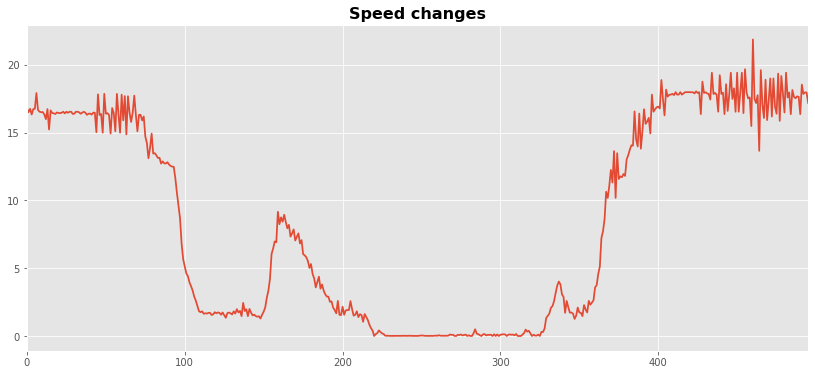

In [9]:
plt.figure(figsize=(14,6))
plt.margins(x=0)
plt.rc('axes',edgecolor='k',linewidth=2)
plt.title('Speed changes',fontsize=16, fontweight='bold',c='black')
plt.plot(speed, label='Speed',linewidth=1.75)
plt.show()

In [10]:
print(f'Mean speed (given in df) :{mean(gdf.speed)}')
print(f'Mean speed (calculated from points) :{mean(speed)}')
print(f'Differece of means :{abs(mean(gdf.speed)-mean(speed))}')


Mean speed (given in df) :8.467203219315898
Mean speed (calculated from points) :8.476418428994142
Differece of means :0.009215209678243852


In [11]:
step = cm.StepColormap(['red','blue','green'],
                       vmin=0, vmax=30, index=[0,5,10,30],
                       caption='Speed')

m=gdf[['vessel_id','speed','geometry']].explore(column='speed',cmap=step,tiles=xyz.CartoDB.Voyager,popup=True,name='Ship')
ports[['name','geometry']].explore(m=m,name='Ports')
folium.LayerControl().add_to(m)
m

In [12]:
nearest_port={}
for j in gdf.geometry:
    for i,p in enumerate(ports.name):
        dist=ports.geometry[i].distance(j)/1852

        if dist<0.5 and p not in nearest_port.keys():
            nearest_port[p]=dist
        elif p in nearest_port.keys() and dist<nearest_port[p]:
            nearest_port[p]=dist

In [13]:
nearest_port

{'PIRAEUS': 0.0}